<a href="https://colab.research.google.com/github/pkalra001/ML/blob/master/HomeLoan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from scipy.stats import skew
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

### GREETING THE DATA

In [ ]:
df = pd.read_csv("data_set.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loamount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360,1,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360,1,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777.0,113.0,360,1,Urban,Y
977,LP002975,Male,Yes,0,Graduate,No,4158,709.0,115.0,360,1,Urban,Y
978,LP002980,Male,No,0,Graduate,No,3250,1993.0,126.0,360,1,Semiurban,Y
979,LP002986,Male,Yes,0,Graduate,No,5000,2393.0,158.0,360,1,Rural,Y


Looking up the datatypes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             981 non-null    object 
 2   Married            981 non-null    object 
 3   Dependents         981 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      981 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   Loamount           954 non-null    float64
 9   Loan_Amount_Term   981 non-null    int64  
 10  Credit_History     981 non-null    int64  
 11  Property_Area      981 non-null    object 
 12  Loan_Status        981 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 99.8+ KB


Only 'Loamount' has null values. We will be imputing it after splitting the data to prevent data leakage.

In [ ]:
df.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
Loamount             27
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

Value counts to identify the categories in the categorical columns. Credit_history had only two values but having int64 dtype so its been converted to object dtype.

In [ ]:
for column in df.columns:
  print(df[column].value_counts())

LP001098    1
LP001547    1
LP002311    1
LP001558    1
LP002489    1
           ..
LP002083    1
LP002326    1
LP002086    1
LP001653    1
LP001868    1
Name: Loan_ID, Length: 981, dtype: int64
Male      799
Female    182
Name: Gender, dtype: int64
Yes    634
No     347
Name: Married, dtype: int64
0     570
2     160
1     160
3+     91
Name: Dependents, dtype: int64
Graduate        763
Not Graduate    218
Name: Education, dtype: int64
No     862
Yes    119
Name: Self_Employed, dtype: int64
2500     13
5000     11
3333     10
3500      9
2600      8
         ..
14999     1
4758      1
4755      1
4364      1
3691      1
Name: ApplicantIncome, Length: 752, dtype: int64
0.0       429
2500.0      6
2083.0      5
2000.0      5
2333.0      5
         ... 
1131.0      1
4700.0      1
2374.0      1
5302.0      1
3422.0      1
Name: CoapplicantIncome, Length: 437, dtype: int64
120.0    29
110.0    27
100.0    24
187.0    21
150.0    19
         ..
196.0     1
400.0     1
250.0     1
500.0    

## PLOTTING THE DATA

Plotting categorical columns with the target variable 'Loan_Status'

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Credit_History', 'Property_Area'],
      dtype='object')


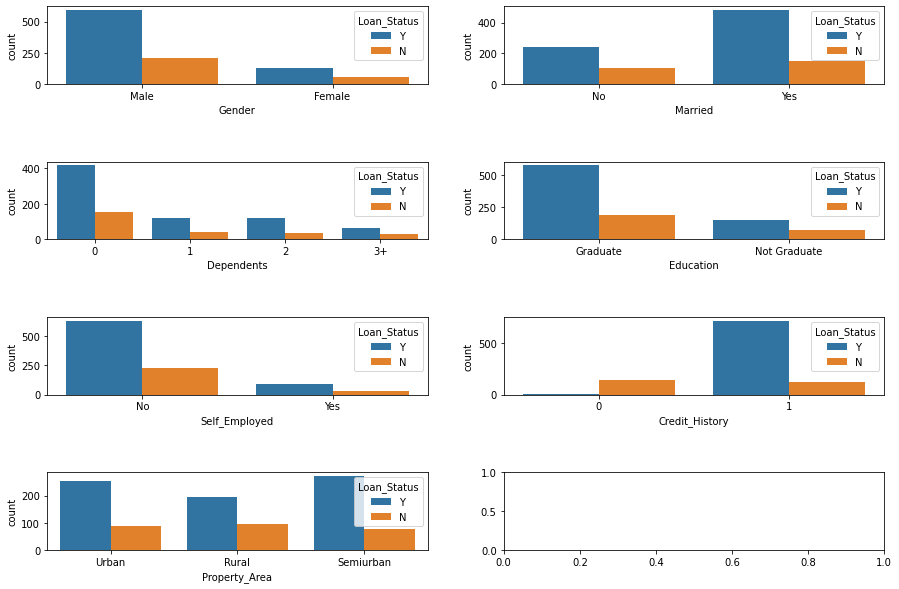

In [ ]:
df.drop('Loan_ID', axis = 1, inplace = True)
df['Credit_History'] = df['Credit_History'].astype('object')
categorical_columns = df.dtypes[df.dtypes == "object"].index.drop('Loan_Status')
print(categorical_columns)
fig, ax = plt.subplots(4,2, figsize = (15, 10))
for index, column in enumerate(categorical_columns):
  row, col = index//2, index%2
  sns.countplot(x = column, data=df, hue='Loan_Status', ax = ax[row,col])
  #print(column)

plt.subplots_adjust(hspace=1)

# Inferences:
1. Male applicants outnumber females by almost three times.
2. Married candidates were granted loan more often.
3. Candidates with no dependents applied for the loans mostly and were likely to be granted.
4. Maximum applicants are educated and were more likely to be granted loan.
5. Majority of the candidates are not self employed.
6. Credit history leads to more approvals.
7. Area doesnt seem to have much effect on the applicants and approvals


Plotting the approvals vs non-approvals shows a class disbalance of almost 3x.

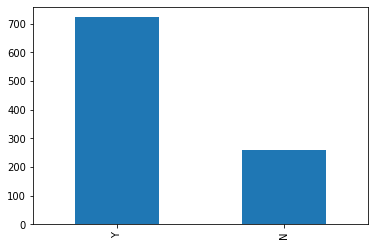

In [ ]:
df['Loan_Status'].value_counts().plot(kind = 'bar')

Plotting the numerical columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd38b6a2240>,
      dtype=object)

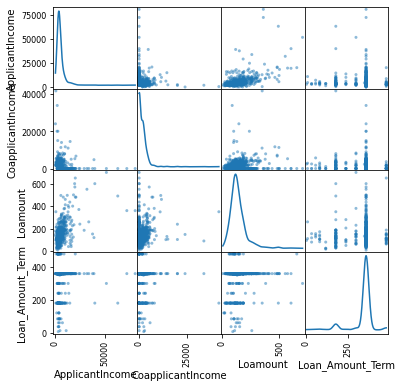

In [ ]:
pd.plotting.scatter_matrix(df, figsize = (6,6), diagonal = 'kde')

KDE plots above show that most of the numerical data is skewed.

# PREPROCESSING

Calculating the skewness in the data.

In [ ]:
numeric_features = df.dtypes[df.dtypes != "object"].index
skewed_feats = df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

,Skew
ApplicantIncome,7.076120
CoapplicantIncome,6.833639
Loamount,2.709767
Loan_Amount_Term,-2.509884


Reducing the skewness using log transformations.

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df[feat] = boxcox1p(df[feat], lam)

Correlation plot is plotted after the log transformations.

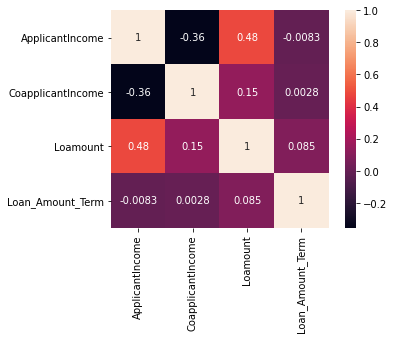

In [ ]:
#plt.figure(figsize = (20, 20))
sns.heatmap(df.corr(), annot = True, square = True)

There is not any significant correlations between the features.

Hot encoding the target variable 'Loan_Status' and making a dictionary with mapping to convert back from encodings to 'Y' or 'N'.

In [ ]:
df['target'] = df['Loan_Status'].factorize()[0]
status_target_dict = dict(df[['target', 'Loan_Status']].drop_duplicates().sort_values('target').values)
df.drop(['Loan_Status'], axis = 1, inplace = True)

Splitting with stratify to ensure the balanced splitting.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), df['target'], test_size = 0.1, random_state = 23, stratify = df['target'])

Imputing the null values with medians. Imputing with respective medians ensures no data leakage.

In [ ]:
x_train['Loamount'] = x_train['Loamount'].fillna(x_train['Loamount'].median()) 
x_test['Loamount'] = x_test['Loamount'].fillna(x_test['Loamount'].median())

Data frame has been encoded using the sklearn's one hot encoder instead of pandas' get_dummies because the latter can't handle new categories in the test data which were not present in the train data.

In [ ]:
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
encoder.fit(x_train[x_train.select_dtypes(include = 'object').columns])
train_trans = encoder.transform(x_train[x_train.select_dtypes(include = 'object').columns])
test_trans = encoder.transform(x_test[x_test.select_dtypes(include = 'object').columns])
X = pd.DataFrame(train_trans)
test = pd.DataFrame(test_trans)
X = pd.concat([X, x_train.reset_index(drop = True)], axis = 1)
test = pd.concat([test, x_test.reset_index(drop = True)], axis = 1)
X.drop(X.select_dtypes(include = 'object').columns, axis = 1, inplace = True)
test.drop(test.select_dtypes(include = 'object').columns, axis = 1, inplace = True)

The number of features is not large so I would be skipping feature selection both ways i.e. before modelling and after modelling.

# MODELLING

Deciding the split strategy.

In [ ]:
cv_split = ShuffleSplit(n_splits = 5, test_size = 0.2, train_size = 0.75, random_state = 0)

For Logistic Regression the data needs to be scaled so I will be using pipeline to handle the scaling on the train and cv data automatically. RobustScaler has been used to handle the outliers better.

In [ ]:
pipe_lr = Pipeline([('scaler', RobustScaler()), ('lr', LogisticRegression())])
param_grid_lr = [{'lr__C' : [0.1, 1, 10]}]
best_search_lr = GridSearchCV(estimator = pipe_lr, param_grid = param_grid_lr, cv = cv_split, scoring = 'accuracy', n_jobs = -1)
best_search_lr.fit(X, y_train)
print("Best parameters for SVC : {}".format(best_search_lr.best_params_))
print("Cross-validation score for SVC : {}".format(best_search_lr.best_score_))
print("Test score for SVC : {}".format(accuracy_score(y_test, best_search_lr.predict(test))))

Best parameters for SVC : {'lr__C': 0.1}
Cross-validation score for SVC : 0.8858757062146893
Test score for SVC : 0.898989898989899


SVM will employed with the similary strategy as Logistic Regression 

In [ ]:
pipe_SVC = Pipeline([('scaler', RobustScaler()), ('SVC', SVC())])
param_grid_SVC = [{'SVC__C' : [0.1, 1, 10]}]
best_search_SVC = GridSearchCV(estimator = pipe_SVC, param_grid = param_grid, cv = cv_split, scoring = 'accuracy', n_jobs = -1)
best_search_SVC.fit(X, y_train)
print("Best parameters for SVC : {}".format(best_search_SVC.best_params_))
print("Cross-validation score for SVC : {}".format(best_search_SVC.best_score_))
print("Test score for SVC : {}".format(accuracy_score(y_test, best_search_SVC.predict(test))))

Best parameters for SVC : {'SVC__C': 1}
Cross-validation score for SVC : 0.8858757062146893
Test score for SVC : 0.898989898989899


XGB has been tuned with randomized search 

In [ ]:
random_grid_xgb = {
        'silent': [False],
        'max_depth': [3, 6, 10],
        'learning_rate': [ 0.01, 0.05, 0.1, 0.2],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.4, 0.7, 0.9],
        'colsample_bylevel': [0.4, 0.7, 0.9],
        'min_child_weight': [0.5, 1.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.5, 1, 5],
        'reg_lambda': [0.1, 1.0, 10.0, 50.0],
        'n_estimators': [1000, 3000]}

xgb_random = RandomizedSearchCV(estimator = XGBClassifier(random_state = 38), param_distributions = random_grid_xgb, 
                               scoring = 'accuracy', n_iter = 60, cv = cv_split, verbose=3, random_state=38, n_jobs = -1)
xgb_random.fit(X, y_train)
print("Best parameters for XGB : {}".format(xgb_random.best_params_))
print("Cross-validation score for XGB : {}".format(xgb_random.best_score_))
print("Test score for XGB : {}".format(accuracy_score(y_test, xgb_random.predict(test))))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


Best parameters for XGB : {'subsample': 0.7, 'silent': False, 'reg_lambda': 10.0, 'n_estimators': 3000, 'min_child_weight': 5.0, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7}
Cross-validation score for XGB : 0.8870056497175142
Test score for XGB : 0.8888888888888888


Random Forest have been employed with randomized search too. As expected it was quite slow.

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 42), param_distributions = random_grid_rf, 
                               n_iter = 60, cv = cv_split, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X, y_train)
print("Best parameters for Random Forest : {}".format(rf_random.best_params_))
print("Cross-validation score for Random Forest : {}".format(rf_random.best_score_))
print("Test score for Random Forest : {}".format(accuracy_score(y_test, rf_random.predict(test))))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.8min finished


Best parameters for Random Forest : {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Cross-validation score for Random Forest : 0.8858757062146893
Test score for Random Forest : 0.898989898989899
